In [1]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from glob import glob
from PIL import Image
import seaborn as sns
import math
import random
import xarray as xr
from torch.masked import masked_tensor, as_masked_tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')#[0:500]

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')#[0:500]

In [3]:
# these are set by finding the min and max across the entire dataset
norm_dict = {'aso_sd':[0, 24.9],
             'vv':[0, 13523.8],
             'vh':[0, 43.2],
             'AOT':[0, 572.1],
             'coastal':[0, 23459.1],
             'blue':[0, 23004.1],
             'green':[0, 26440.1],
             'red':[0, 21576.1],
             'red_edge1':[0, 20796.1],
             'red_edge2':[0, 20432.1],
             'red_edge3':[0, 20149.1],
             'nir':[0, 21217.1],
             'water_vapor':[0, 18199.1],
             'swir1':[0, 17549.1],
             'swir2':[0, 17314.1],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6517.5],
             'elevation':[-100, 9000]}

In [4]:
def calc_norm(tensor, minmax_list):
    '''
    normalize a tensor between 0 and 1 using a min and max value stored in a list
    '''
    normalized = (tensor-minmax_list[0])/(minmax_list[1]-minmax_list[0])
    return normalized

In [5]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    '''
    class that reads data from a netCDF and returns normalized tensors 
    '''
    def __init__(self, path_list, norm_dict, norm=True):
        self.path_list = path_list
        self.norm_dict = norm_dict
        self.norm = norm
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.path_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        ds = xr.open_dataset(self.path_list[idx])
        #ds = ds.coarsen(x = 6, boundary = 'trim').mean().coarsen(y = 6, boundary = 'trim').mean()
        # convert to tensors
        aso_sd = torch.from_numpy(np.float32(ds.aso_sd.values))
        snowon_vv = torch.from_numpy(np.float32(ds.snowon_vv.values))
        snowon_vh = torch.from_numpy(np.float32(ds.snowon_vh.values))
        snowoff_vv = torch.from_numpy(np.float32(ds.snowoff_vv.values))
        snowoff_vh = torch.from_numpy(np.float32(ds.snowoff_vh.values))
        snowon_vv_mean = torch.from_numpy(np.float32(ds.snowon_vv_mean.values))
        snowon_vh_mean = torch.from_numpy(np.float32(ds.snowon_vh_mean.values))
        snowoff_vv_mean = torch.from_numpy(np.float32(ds.snowoff_vv_mean.values))
        snowoff_vh_mean = torch.from_numpy(np.float32(ds.snowoff_vh_mean.values))
        aerosol_optical_thickness = torch.from_numpy(np.float32(ds.AOT.values))
        coastal_aerosol = torch.from_numpy(np.float32(ds.B01.values))
        blue = torch.from_numpy(np.float32(ds.B02.values))
        green = torch.from_numpy(np.float32(ds.B03.values))
        red = torch.from_numpy(np.float32(ds.B04.values))
        red_edge1 = torch.from_numpy(np.float32(ds.B05.values))
        red_edge2 = torch.from_numpy(np.float32(ds.B06.values))
        red_edge3 = torch.from_numpy(np.float32(ds.B07.values))
        nir = torch.from_numpy(np.float32(ds.B08.values))
        water_vapor = torch.from_numpy(np.float32(ds.B09.values))
        swir1 = torch.from_numpy(np.float32(ds.B11.values))
        swir2 = torch.from_numpy(np.float32(ds.B12.values))
        scene_class_map = torch.from_numpy(np.float32(ds.SCL.values))
        water_vapor_product = torch.from_numpy(np.float32(ds.WVP.values))
        fcf = torch.from_numpy(np.float32(ds.fcf.values))
        elevation = torch.from_numpy(np.float32(ds.elevation.values))
        aso_gap_map = torch.from_numpy(np.float32(ds.aso_gap_map.values))
        rtc_gap_map = torch.from_numpy(np.float32(ds.rtc_gap_map.values))
        rtc_mean_gap_map = torch.from_numpy(np.float32(ds.rtc_mean_gap_map.values))

        # calculate some other inputs for our CNN
        ndvi = (nir - red)/(nir + red)
        ndsi = (green - swir1)/(green + swir1)
        ndwi = (green - nir)/(green + nir)

        snowon_ratio = (snowon_vv - snowon_vh)/(snowon_vv + snowon_vh)
        snowoff_ratio = (snowoff_vv - snowoff_vh)/(snowoff_vv + snowoff_vh)
            
        # normalize layers (except gap maps and fcf)
        if self.norm == True:
            aso_sd = calc_norm(aso_sd, self.norm_dict['aso_sd'])
            snowon_vv = calc_norm(snowon_vv, self.norm_dict['vv'])
            snowon_vh = calc_norm(snowon_vh, self.norm_dict['vh'])
            snowoff_vv = calc_norm(snowoff_vv, self.norm_dict['vv'])
            snowoff_vh = calc_norm(snowoff_vh, self.norm_dict['vh'])
            snowon_vv_mean = calc_norm(snowon_vv_mean, self.norm_dict['vv'])
            snowon_vh_mean = calc_norm(snowon_vh_mean, self.norm_dict['vh'])
            snowoff_vv_mean = calc_norm(snowoff_vv_mean, self.norm_dict['vv'])
            snowoff_vh_mean = calc_norm(snowoff_vh_mean, self.norm_dict['vh'])
            aerosol_optical_thickness = calc_norm(aerosol_optical_thickness, self.norm_dict['AOT'])
            coastal_aerosol = calc_norm(coastal_aerosol, self.norm_dict['coastal'])
            blue = calc_norm(blue, self.norm_dict['blue'])
            green = calc_norm(green, self.norm_dict['green'])
            red = calc_norm(red, self.norm_dict['red'])
            red_edge1 = calc_norm(red_edge1, self.norm_dict['red_edge1'])
            red_edge2 = calc_norm(red_edge2, self.norm_dict['red_edge2'])
            red_edge3 = calc_norm(red_edge3, self.norm_dict['red_edge3'])
            nir = calc_norm(nir, self.norm_dict['nir'])
            water_vapor = calc_norm(water_vapor, self.norm_dict['water_vapor'])
            swir1 = calc_norm(swir1, self.norm_dict['swir1'])
            swir2 = calc_norm(swir2, self.norm_dict['swir2'])
            scene_class_map = calc_norm(scene_class_map, self.norm_dict['scene_class_map'])
            water_vapor_product = calc_norm(water_vapor_product, self.norm_dict['water_vapor_product'])
            elevation = calc_norm(elevation, self.norm_dict['elevation'])
            ndvi = torch.nan_to_num(calc_norm(ndvi, [-1, 1]), 0)
            ndsi = torch.nan_to_num(calc_norm(ndsi, [-1, 1]), 0)
            ndwi = torch.nan_to_num(calc_norm(ndwi, [-1, 1]), 0)
            snowon_ratio = torch.nan_to_num(calc_norm(snowon_ratio, [-1, 1]), 0)
            snowoff_ratio = torch.nan_to_num(calc_norm(snowoff_ratio, [-1, 1]), 0)
        
         
        # return only selected bands, for now
        return aso_sd[None, :, :], snowon_vv[None, :, :], snowon_vh[None, :, :], snowoff_vv[None, :, :], snowoff_vh[None, :, :], blue[None, :, :], green[None, :, :], red[None, :, :], fcf[None, :, :], elevation[None, :, :], aso_gap_map[None, :, :], rtc_gap_map[None, :, :], ndvi[None, :, :], ndsi[None, :, :], ndwi[None, :, :], snowon_ratio[None, :, :], snowoff_ratio[None, :, :] 

In [6]:
# create dataloaders
train_data = dataset(train_path_list, norm_dict, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = dataset(val_path_list, norm_dict, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [7]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)


def check_valid_activation(choice):
    if choice not in ['relu', 'lrelu', 'prelu']:
        raise ValueError(f"'{choice}' is not a valid activation function. Choose among ['relu', 'lrelu', 'prelu'].\n")


def upconv(in_channels, out_channels, mode='transpose'):
    # stride=2 implies upsampling by a factor of 2
    get_up_mode = nn.ModuleDict([
        ['bilinear', nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), conv1x1(in_channels, out_channels))],
        ['transpose', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)]
    ])

    return get_up_mode[mode]


def get_activation(choice):
    activation_functions = nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['lrelu', nn.LeakyReLU(inplace=True)],
        ['prelu', nn.PReLU()]
        ])
    return activation_functions[choice]


def conv_block(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Partial encoder block consisting of a 3×3 convolutional layer with stride 1, followed by batch normalization
    (optional) and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


def conv_up_block(in_channels, out_channels, activation='relu', do_BN=True, up_mode='transpose', *args, **kwargs):
    """
    Decoder block consisting of an up-convolutional layer, followed by a 3×3 convolutional layer with stride 1,
    batch normalization (optional), and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                get_activation(activation))
            )
    else:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
                get_activation(activation))
            )


def bottleneck(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Bottleneck block.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


class SkipConnection(nn.Module):
    def __init__(self):
        super(SkipConnection, self).__init__()

    def forward(self, x_skip, x_up):
        return x_skip + x_up


class UNet(nn.Module):
    def __init__(self, n_input_channels=14, start_kernel=64, max_filter_depth=512, depth=6,
                 act_fn_encoder='relu', act_fn_decoder='relu', act_fn_bottleneck='relu', up_mode='transpose',
                 do_BN=False, bias_conv_layer=True, outer_skip=True, outer_skip_BN=False):
        """
        UNet network architecture.
        :param n_input_channels:    int, number of input channels
        :param start_kernel:        int, number of filters of the first convolutional layer in the encoder
        :param max_filter_depth:    int, maximum filter depth
        :param depth:               int, number of downsampling and upsampling layers (i.e., number of blocks in the
                                    encoder and decoder)
        :param act_fn_encoder:      str, activation function used in the encoder
        :param act_fn_decoder:      str, activation function used in the decoder
        :param act_fn_bottleneck:   str, activation function used in the bottleneck
        :param up_mode:             str, upsampling mode
        :param do_BN:               boolean, True to perform batch normalization after every convolutional layer,
                                    False otherwise
        :param bias_conv_layer:     boolean, True to activate the learnable bias of the convolutional layers,
                                    False otherwise
        :param outer_skip:          boolean, True to activate the long residual skip connection that adds the
                                    initial DSM to the output of the last decoder layer, False otherwise
        :param outer_skip_BN:       boolean, True to add batch normalization to the long residual skip connection,
                                    False otherwise
        """

        super(UNet, self).__init__()

        check_valid_activation(act_fn_encoder)
        check_valid_activation(act_fn_decoder)
        check_valid_activation(act_fn_bottleneck)

        if up_mode not in ['transpose', 'bilinear']:
            raise ValueError(f"'{up_mode}' is not a valid mode for upsampling. Choose among ['transpose', 'bilinear'] "
                             "to specify 'up_mode'.\n")

        self.n_input_channels = n_input_channels
        self.start_kernel = start_kernel
        self.depth = depth
        self.act_fn_encoder = act_fn_encoder
        self.act_fn_decoder = act_fn_decoder
        self.act_fn_bottleneck = act_fn_bottleneck
        self.up_mode = up_mode
        self.max_filter_depth = max_filter_depth
        self.do_BN = do_BN
        self.bias_conv_layer = bias_conv_layer
        self.do_outer_skip = outer_skip
        self.do_outer_skip_BN = outer_skip_BN
        self.filter_depths = [self.start_kernel * (2 ** i) for i in range(self.depth)]

        # Restrict the maximum filter depth to a predefined value
        self.filter_depths = [self.max_filter_depth if i > self.max_filter_depth else i for i in self.filter_depths]

        # Set up the encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Sequential(
            conv_block(self.n_input_channels, self.start_kernel, activation=self.act_fn_encoder, do_BN=self.do_BN),
            nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        for in_channel, out_channel in zip(self.filter_depths, self.filter_depths[1:]):
            self.encoder.append(nn.Sequential(
                conv_block(in_channel, out_channel, activation=self.act_fn_encoder, do_BN=self.do_BN),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        # Set up the bottleneck
        self.bottleneck = bottleneck(self.filter_depths[-1], self.filter_depths[-1], activation=self.act_fn_bottleneck,
                                     do_BN=self.do_BN)

        # Set up the decoder
        self.decoder = nn.ModuleList()
        self.filter_depths_up = list(reversed(self.filter_depths))

        for in_channel, out_channel in zip(self.filter_depths_up[:-1], self.filter_depths_up[1:]):
            self.decoder.append(conv_up_block(in_channel, out_channel, activation=self.act_fn_decoder,
                                              up_mode=self.up_mode, do_BN=self.do_BN))
        self.decoder.append(upconv(self.filter_depths_up[-1], self.filter_depths_up[-1], up_mode))

        # Set up the final layer of the decoder
        self.last_layer = conv3x3(self.start_kernel, 1, bias=self.bias_conv_layer)

        # Skip connection
        self.skipconnect = SkipConnection()

        # Batch normalization added to the long residual skip connection
        if self.do_outer_skip:
            self.layer_outer_skip = nn.ModuleList()
            if self.do_outer_skip_BN:
                self.layer_outer_skip.append(nn.BatchNorm2d(1))
            self.layer_outer_skip.append(SkipConnection())

    def forward(self, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, ndvi, ndsi, ndwi, snowon_ratio, snowoff_ratio):
        skip_connections = []
        x = torch.cat((snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, ndvi, ndsi, ndwi, snowon_ratio, snowoff_ratio), dim=1)
        out = x

        # Encoder (save intermediate outputs for skip connections)
        for index, layer in enumerate(self.encoder):
            layer_conv = layer[:-1]  # all layers before the pooling layer (at depth index)
            layer_pool = layer[-1]   # pooling layer (at depth index)

            out_before_pool = layer_conv(out)
            skip_connections.append(out_before_pool)
            out = layer_pool(out_before_pool)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder + skip connections
        index_max = len(self.decoder) - 1
        for index, layer in enumerate(self.decoder):
            if index <= index_max - 1:
                layer_upconv = layer[0]  # upconv layer
                layer_conv = layer[1::]  # all other layers (conv, batchnorm, activation)

                out_temp = layer_upconv(out)
                out = self.skipconnect(skip_connections[-1 - index], out_temp)
                out = layer_conv(out)
            else:
                out_temp = layer(out)   # upconv of last layer
                out = self.skipconnect(skip_connections[-1 - index], out_temp)

        # Last layer of the decoder
        out = self.last_layer(out)

        # Add long residual skip connection
        if self.do_outer_skip:
            if self.layer_outer_skip.__len__() == 2:
                # pipe input through a batch normalization layer before adding it to the output of the last
                # decoder layer
                bn = self.layer_outer_skip[0]
                x_0 = x[:, 0, :, :]       # use channel 0 only
                x_0 = x_0.unsqueeze(1)
                x = bn(x_0)

            # add (batchnorm) input to the output of the last decoder layer
            add = self.layer_outer_skip[-1]
            x_0 = x[:, 0, :, :]
            x_0 = x_0.unsqueeze(1)

            out = add(x_0, out)  # use channel 0 only

        return out

In [8]:
#load previous model
model = UNet()
model.load_state_dict(torch.load('../../weights/quinn_modelv1'))
model.to('cuda')

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, 

In [9]:
# %%time
# model = UNet()
# #Define optimizer
# model.to('cuda') # run on gpu
# optimizer = optim.AdamW(model.parameters(), lr=0.0003)
# loss_fn   = nn.MSELoss()
# epochs = 50
# #torch.autograd.set_detect_anomaly(True)

# train_loss = []
# val_loss = []

# for epoch in range(epochs):
#     print(f'\nstarting epoch {epoch}')
#     epoch_loss = []
#     val_temp_loss = []
    
#     #loop through training data 
#     for (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi, snowon_ratio, snowoff_ratio) in train_loader:
#         model.train()
#         optimizer.zero_grad()
#         pred_sd = torch.clamp(model(snowon_vv.to('cuda'), snowon_vh.to('cuda'), snowoff_vv.to('cuda'), snowoff_vh.to('cuda'), blue.to('cuda'), green.to('cuda'), red.to('cuda'), fcf.to('cuda'), elevation.to('cuda'), ndvi.to('cuda'), ndsi.to('cuda'), ndwi.to('cuda'), snowon_ratio.to('cuda'), snowoff_ratio.to('cuda')), 0, 1) # Generate noise predictions

#         # limit prediction to areas with valid data 
#         pred_sd = torch.where(aso_gap_map.to('cuda')+rtc_gap_map.to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
#         aso_sd = torch.where(aso_gap_map.to('cuda')+rtc_gap_map.to('cuda') == 0, aso_sd.to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
#         # calculate predicted signals 
#         loss = loss_fn(pred_sd, aso_sd.to('cuda')) # calculate loss
        
#         epoch_loss.append(loss.item()) # add batch loss to epoch loss list
        
#         loss.backward() #Propagate the gradients in backward pass
#         optimizer.step() 

#     train_loss.append(np.mean(epoch_loss))
#     print(f'training loss: {np.mean(epoch_loss)}')
    
#     # run model on validation data 
#     for (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi, snowon_ratio, snowoff_ratio) in val_loader:
#         with torch.no_grad():
#             model.eval()
            
#             pred_sd = torch.clamp(model(snowon_vv.to('cuda'), snowon_vh.to('cuda'), snowoff_vv.to('cuda'), snowoff_vh.to('cuda'), blue.to('cuda'), green.to('cuda'), red.to('cuda'), fcf.to('cuda'), elevation.to('cuda'), ndvi.to('cuda'), ndsi.to('cuda'), ndwi.to('cuda'), snowon_ratio.to('cuda'), snowoff_ratio.to('cuda')), 0, 1) #Generate predictions using the model

#             pred_sd = torch.where(aso_gap_map.to('cuda')+rtc_gap_map.to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
#             aso_sd = torch.where(aso_gap_map.to('cuda')+rtc_gap_map.to('cuda') == 0, aso_sd.to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
           
#             loss = loss_fn(pred_sd.to('cuda'), aso_sd.to('cuda')) #Loss/error
#             val_temp_loss.append(loss.item())
    
#     val_loss.append(np.mean(val_temp_loss))
#     print(f'validation loss: {np.mean(val_temp_loss)}')
#     torch.save(model.state_dict(), f'../weights/quinn_modelv1')

In [ ]:
# #plot loss over all epochs
# f, ax = plt.subplots(figsize=(10,5))
# ax.plot(train_loss, label='training')
# ax.plot(val_loss, label='validation')
# ax.set_xlabel('epoch')
# ax.set_ylabel('L1 loss')
# ax.set_title('Loss')
# ax.legend()
# plt.savefig('../figs/quinn_movelv1_loss1.png', dpi=300)

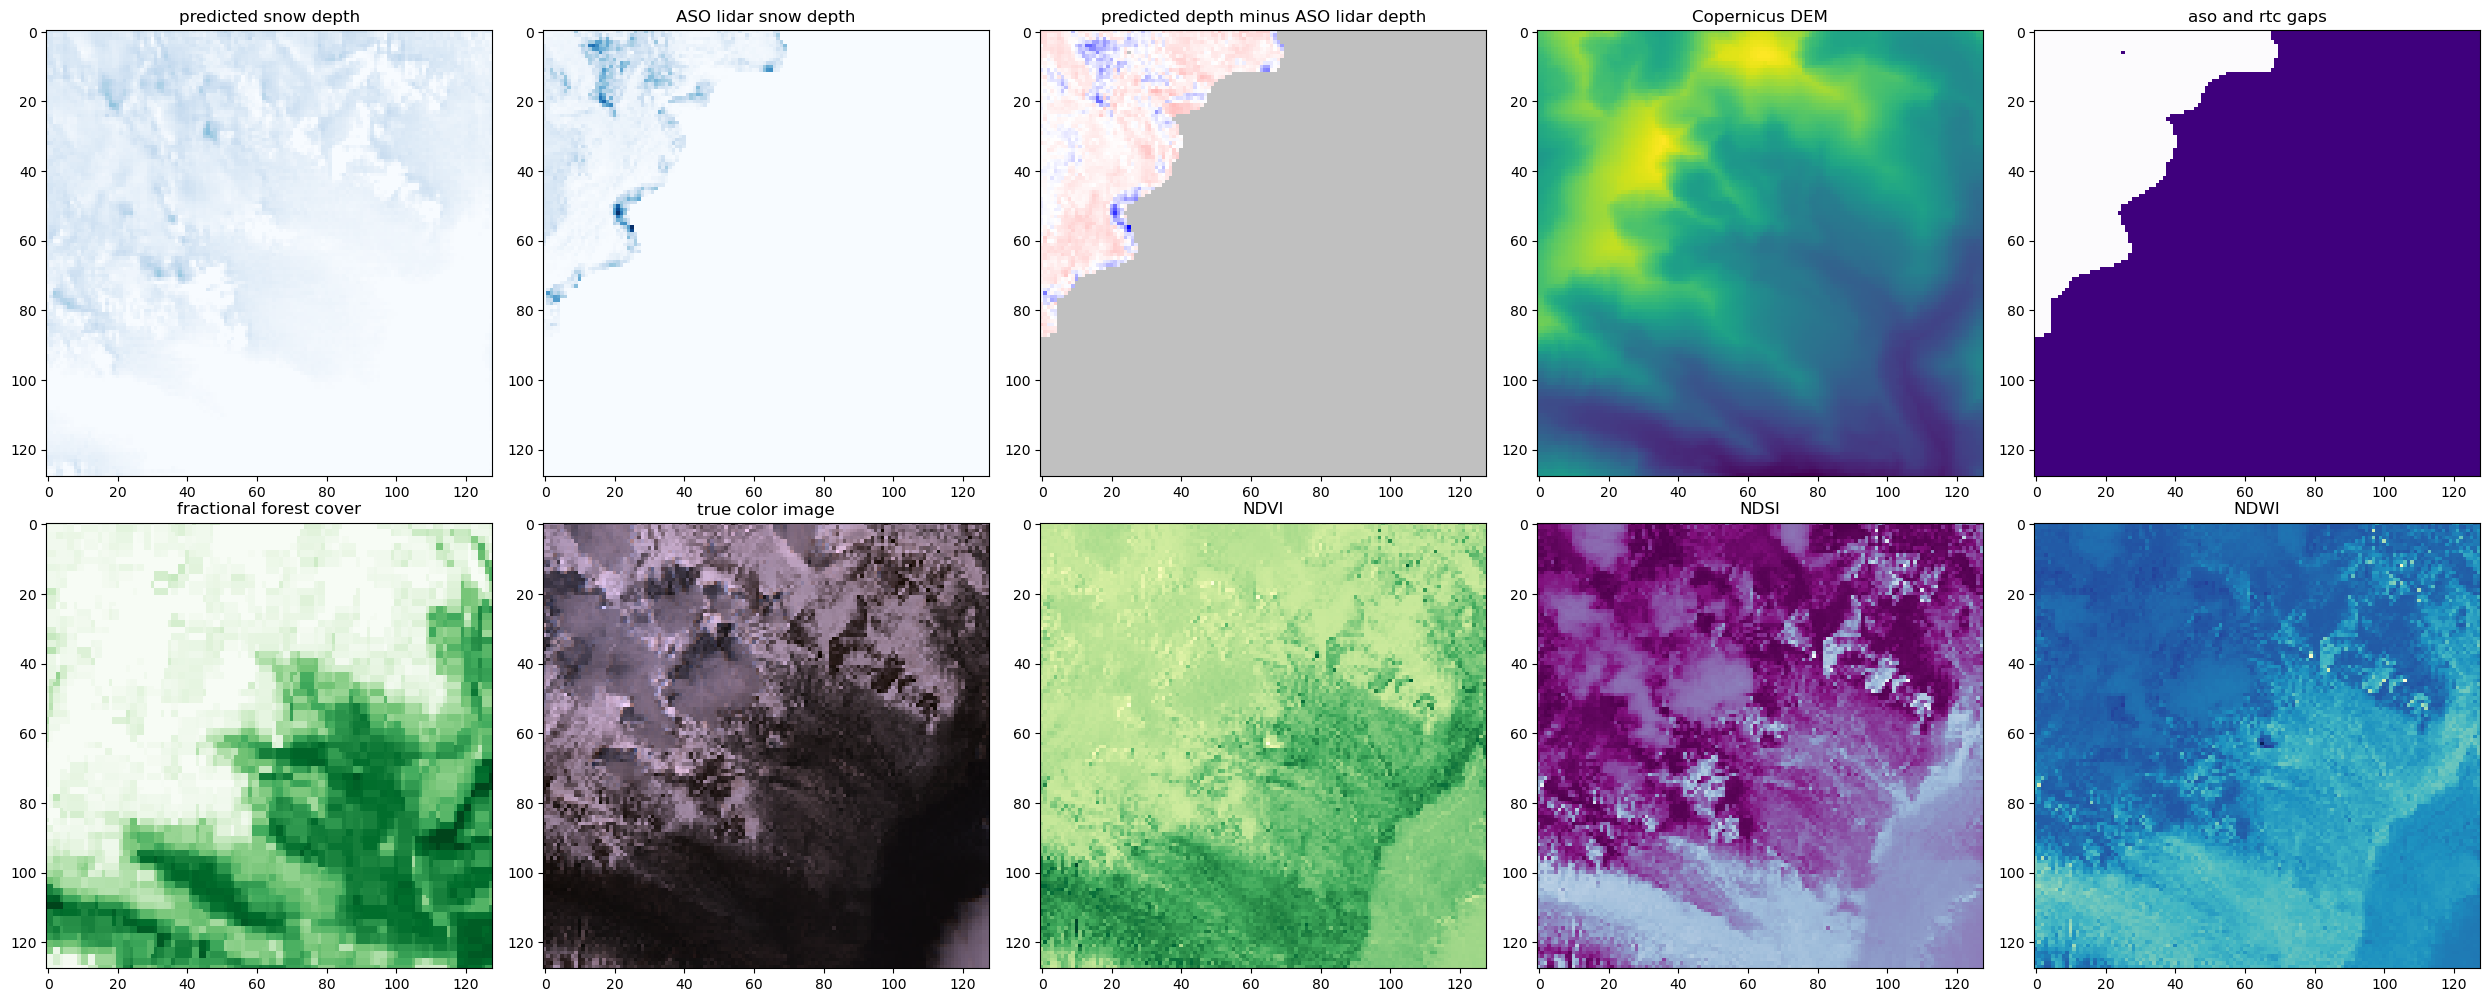

In [13]:
# visualize model outputs
num_images=1

masked_cmap = mpl.colormaps.get_cmap('bwr')
masked_cmap.set_bad('silver')            

for i, (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi, snowon_ratio, snowoff_ratio) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            pred_sd = model(snowon_vv.to('cuda'), snowon_vh.to('cuda'), snowoff_vv.to('cuda'), snowoff_vh.to('cuda'), blue.to('cuda'), green.to('cuda'), red.to('cuda'), fcf.to('cuda'), elevation.to('cuda'), ndvi.to('cuda'), ndsi.to('cuda'), ndwi.to('cuda'), snowon_ratio.to('cuda'), snowoff_ratio.to('cuda')) #Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            masked_diff = np.ma.fix_invalid((pred_sd.squeeze()-aso_sd.squeeze()), mask=(aso_gap_map.squeeze()+rtc_gap_map.squeeze()), fill_value=np.nan)
            
            f, ax = plt.subplots(2, 5, figsize=(25,10))
            ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None) 
            ax[0, 0].set_title('predicted snow depth')
            ax[0, 1].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
            ax[0, 1].set_title('ASO lidar snow depth')
            ax[0, 2].imshow(masked_diff, cmap=masked_cmap, vmin=-0.4, vmax=0.4, interpolation=None)
            ax[0, 2].set_title('predicted depth minus ASO lidar depth')
            ax[0, 3].imshow(elevation.squeeze(), cmap='viridis', interpolation='none') 
            ax[0, 3].set_title('Copernicus DEM')
            ax[0, 4].imshow(aso_gap_map.squeeze()+rtc_gap_map.squeeze(), cmap='Purples', interpolation='none') 
            ax[0, 4].set_title('aso and rtc gaps')
            
            ax[1, 0].imshow(fcf.squeeze(), cmap='Greens', interpolation='none') 
            ax[1, 0].set_title('fractional forest cover')
            norm_max = np.max([green.max(), red.max(), blue.max()]) # there are better ways to do this
            ax[1, 1].imshow(torch.cat((red.squeeze()[:, :, None]/norm_max, green.squeeze()[:, :, None]/norm_max, blue.squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none') 
            ax[1, 1].set_title('true color image')
            ax[1, 2].imshow(ndvi.squeeze(), cmap='YlGn', interpolation='none')
            ax[1, 2].set_title('NDVI')
            ax[1, 3].imshow(ndsi.squeeze(), cmap='BuPu', interpolation='none')
            ax[1, 3].set_title('NDSI')
            ax[1, 4].imshow(ndwi.squeeze(), cmap='YlGnBu', interpolation='none')
            ax[1, 4].set_title('NDWI')

            plt.tight_layout()
            #plt.savefig(f'pred_raw{i}.png', dpi=300)
    else: 
        break

In [14]:
from skimage.metrics import structural_similarity as ssim

def ssim_lists(model, data_loader):
    # initialize lists 
    ssim_list = []

    for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        # model preds
        noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
    
        # denormalize
        igram = undo_norm(igram.squeeze().detach())
  
        # calc ssim
        ssim_value = ssim(signal_target.numpy(), igram.numpy(), gaussian_weights=True, data_range=(igram.max()-igram.min()).item())
        ssim_list.append(ssim_value)
        
        return ssim_list

In [15]:
ssim_lists(model, data_loader)

NameError: name 'data_loader' is not defined